# **Machine Learning Final Project:** Death Rate and Average Temperature in New Mexico 

## Predicting Average Temperature

### GRU Model

Import all necessary modules & packages

In [1]:
from keras.models import Sequential
from keras.layers import Dense, GRU, LSTM
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
import joblib
import os

SEED = 42424
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

Load the data

https://github.com/frede791/ml_new_mexico/tree/main/data

In [18]:
# Load the data sets and combine them into a single usable dataframe called data series
data_series = pd.read_csv('./data/data_avg_temp.csv')

# rename columns to be more descriptive
data_series.columns = ['date', 'avg_temp', 'avg_temp_anomaly']
data_series.drop(columns=['avg_temp_anomaly'], inplace=True)

# append to the dataframe
data_cool_degree = pd.read_csv('./data/data_cool_degree_days.csv')
data_heat_degree = pd.read_csv('./data/data_heat_degree_days.csv')
data_max_temp = pd.read_csv('./data/data_max_temp.csv')
data_min_temp = pd.read_csv('./data/data_min_temp.csv')
data_palmer_z = pd.read_csv('./data/data_palmer_z.csv')
data_pdsi = pd.read_csv('./data/data_pdsi.csv')
data_phdi = pd.read_csv('./data/data_phdi.csv')
data_pmdi = pd.read_csv('./data/data_pmdi.csv')
data_precipitation = pd.read_csv('./data/data_precipitation.csv')

# Append columns to the data series
data_series['cool_degree_days'] = data_cool_degree['Value']
data_series['heat_degree_days'] = data_heat_degree['Value']
data_series['max_temp'] = data_max_temp['Value']
data_series['min_temp'] = data_min_temp['Value']
data_series['palmer_z'] = data_palmer_z['Value']
data_series['pdsi'] = data_pdsi['Value']
data_series['phdi'] = data_phdi['Value']
data_series['pmdi'] = data_pmdi['Value']
data_series['precipitation'] = data_precipitation['Value']


Scale the data

In [3]:
# Convert dataframe to numpy array
avg_temp = data_series['avg_temp'].to_numpy()
data_series.drop(columns=['avg_temp'], inplace=True)

# Scale the data
std_scaler = StandardScaler()
x_train_scaled = std_scaler.fit_transform(data_series[['max_temp', 'min_temp', 'cool_degree_days', 'heat_degree_days']])

robust_scaler = RobustScaler()
x_train_scaled = np.append(x_train_scaled, robust_scaler.fit_transform(data_series[['palmer_z', 'pdsi', 'phdi', 'pmdi']]), axis=1)

minmax_scaler = MinMaxScaler()
x_train_scaled = np.append(x_train_scaled, minmax_scaler.fit_transform(data_series[['precipitation']]), axis=1)

joblib.dump(std_scaler, 'std_scaler.joblib')
joblib.dump(robust_scaler, 'robust_scaler.joblib')
joblib.dump(minmax_scaler, 'minmax_scaler.joblib')

# Expand first dim
x_train_scaled = np.expand_dims(x_train_scaled, axis=0)
y_train = np.expand_dims(avg_temp, axis=0)

print(x_train_scaled.shape)

(1, 1537, 9)


Here, we train the GRU model

In [4]:
# Train the GRU model
model_gru = Sequential(
    [
        GRU(20, activation='relu', 
        input_shape=(x_train_scaled.shape[1], x_train_scaled.shape[2])),
        Dense(1)
    ]
)

model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(x_train_scaled, y_train, epochs=100, batch_size=1,verbose=1)

Epoch 1/100


/Users/nicolaaswooters/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - loss: 2772.3857
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 2766.7915
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 2761.1829
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 2755.5637
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 2749.9292
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 2744.2991
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 2738.8496
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 2733.6643
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 2728.4912
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 2723.2859
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 2718.0520
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 2712.7822
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 2707.4604
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 2702.0872
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - l

We want to forecast our average temperature predictions, to do this, we treat each parameter as a target variable with its own model. Each model specializes in learning the unique characteristics of each parameter (variations in precipitation, temperature, etc.).

In [5]:
# Predict the temperature by regressing the other features and then predicting average temperature
parameters = ['max_temp', 'min_temp', 'cool_degree_days', 'heat_degree_days', 'palmer_z', 'pdsi', 'phdi', 'pmdi', 'precipitation']
models = {}
scalers = {}

date = data_series['date'].to_numpy()
date_splice = np.zeros((len(date), 2))

param_models = []

for i, element in enumerate(date):
    # print(element)
    # Splice this string to get year and month
    date_splice[i,0] = int(str(element)[0:4])
    date_splice[i,1] = int(str(element)[5:7])

for param in parameters:
    print(f"PARAM", param)
    y = data_series[param].to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(date_splice, y, test_size=0.2, shuffle=False, random_state=SEED)

    model = Sequential([
        Dense(5, activation='relu', input_shape=(X_train.shape[1],)),  # input_shape=(2,)
        Dense(1)  # Output layer
    ])

    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=1)

    # Save model
    param_models.append(model)

PARAM max_temp
Epoch 1/50


/Users/nicolaaswooters/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 117663.5859 - val_loss: 95074.7266
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - loss: 82266.4844 - val_loss: 69916.7266
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 61069.6289 - val_loss: 52332.2305
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 45786.8984 - val_loss: 39413.6211
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - loss: 34559.9492 - val_loss: 29821.7461
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - loss: 26156.0527 - val_loss: 22609.0352
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 19807.7734 - val_loss: 17117.3418
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 14979.5020 - val_loss: 12898.4043
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 11277.0088 - val_loss: 9641.6963
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - loss: 8410.4990 - val_loss: 7127.6211
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 6195.6797 - v

Here, we predict our parameters (temperature, precipitation, etc.) for the next 60 years on a monthly basis using the pre-trained regression models.

In [9]:
# Prediction of the average temperature
# Using the trained models to predict the parameters and then use those predictions as input for the GRU model

years = 60 # Years in the future
date_predict = np.zeros((years*12, 2))
for i in range(years*12):
    date_predict[i, 0] = 2024 + i // 12
    date_predict[i, 1] = 1 + i % 12

param_predicts = np.zeros((len(parameters),years*12))

#  Predict the parameters
for k, model in enumerate(param_models):
    for i in range(years*12):
        answer = model.predict(date_predict[i].reshape(1, -1))
        param_predicts[k, i] = answer

yearmonth_vec = np.zeros((years*12,1))
for i in range(years*12):
    yearmonth_vec[i] = date_predict[i, 0] * 100 + date_predict[i, 1]

columns = ['max_temp', 'min_temp', 'cool_degree_days', 'heat_degree_days', 'palmer_z', 'pdsi', 'phdi', 'pmdi', 'precipitation']
df_predict = pd.DataFrame(param_predicts.T, columns=columns)

# Normalize the data with the same scalers
predict_scaled = std_scaler.transform(df_predict[['max_temp', 'min_temp', 'cool_degree_days', 'heat_degree_days']])
predict_scaled = np.append(predict_scaled, robust_scaler.transform(df_predict[['palmer_z', 'pdsi', 'phdi', 'pmdi']]), axis=1)
predict_scaled = np.append(predict_scaled, minmax_scaler.transform(df_predict[['precipitation']]), axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/var/folders/ds/s8gbbjqx4pbct0mlwnl6j9sr0000gn/T/ipykernel_58035/3748532855.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  param_predicts[k, i] = answer


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


AttributeError: 'numpy.ndarray' object has no attribute 'head'

The predicted parameters for each year are then fed into our GRU model so that we can forecast predictions for 'avg_temp'.

In [11]:
# Use predicted params for GRU input to predict avg_temp
predictions = []

for i in range(years*12):
    new_timestep = predict_scaled[i,:]
    new_timestep = np.expand_dims(new_timestep, axis=0)
    x = np.append(x_train_scaled[:,1:,:], np.expand_dims(new_timestep, axis=0), axis=1)

    # x = np.expand_dims(params_predicts[i, :], axis=0)
    avg_temp_predict = model_gru.predict(x)
    predictions.append(avg_temp_predict)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

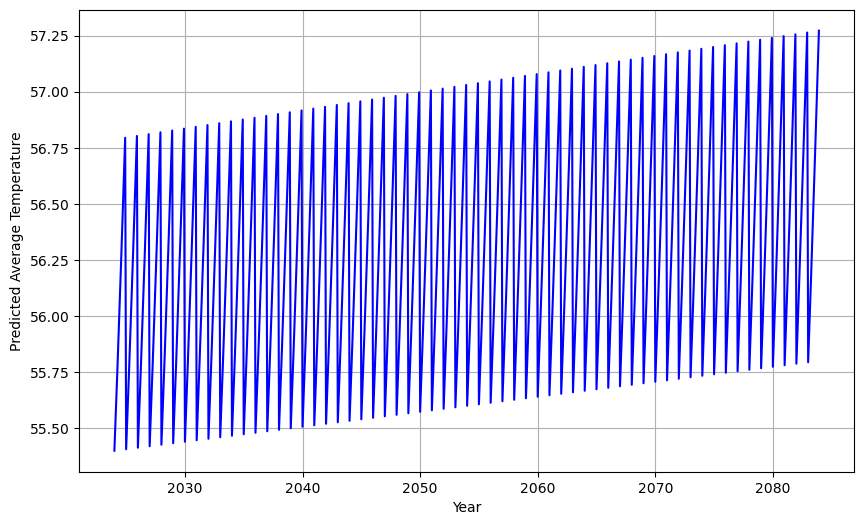

In [12]:
# Flatten predictions
predictions = np.array(predictions).reshape(-1)

# Here I am applying an offset to stabilize our prediction: in this case it aligns our predictions with the LAST known temperature value
offset = 55.4 - predictions[0]
predictions += offset

# Converting the years/months into a float, this is so our x-axis shows the year value, and not how it is stored (202401)
years_float = date_predict[:, 0] + (date_predict[:, 1] - 1) / 12

plt.figure(figsize=(10, 6))
plt.plot(years_float, predictions, color='blue')
plt.xlabel('Year')
plt.ylabel('Predicted Average Temperature')
plt.grid(True)
plt.show()

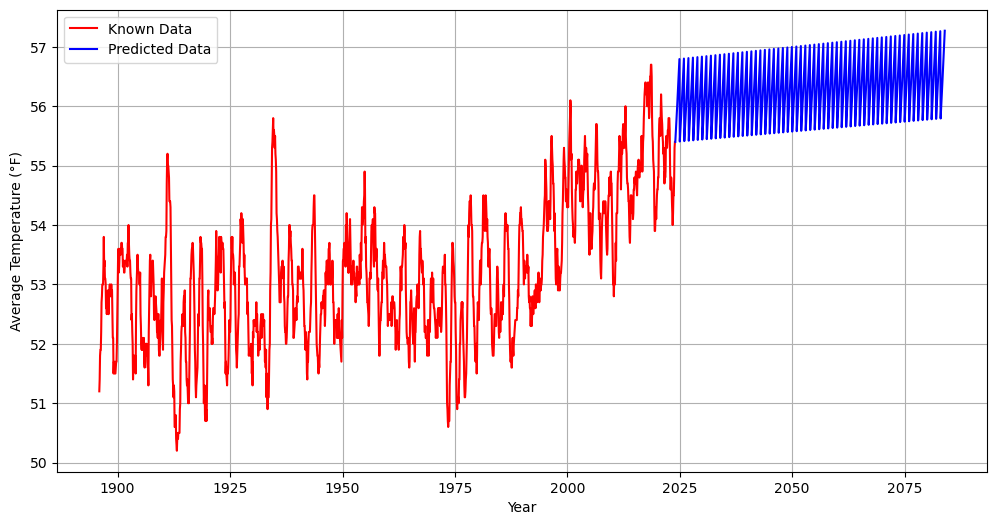

In [20]:
# Read data
known_temperatures = pd.read_csv('./data/data_avg_temp.csv')
# Rename columns for simplicity
known_temperatures.columns = ['date', 'avg_temp', 'avg_temp_anomaly']
# Drop average temperature anomaly (we don't care about it)
known_temperatures.drop(columns=['avg_temp_anomaly'], inplace=True)
# Convert the 'date' column to datetime variable
known_temperatures['date'] = pd.to_datetime(known_temperatures['date'].astype(str), format='%Y%m')
# Grab the year (decimal years)
known_years_float = known_temperatures['date'].dt.year + (known_temperatures['date'].dt.month - 1) / 12
# All of our previous years' temperatures
known_temperatures_values = known_temperatures['avg_temp']

# Here I am applying an offset to stabilize our prediction: in this case it aligns our predictions with the LAST known temperature value
offset = known_temperatures['avg_temp'].iloc[-1] - predictions[0]  # Align predictions to the last known temperature
predictions += offset  # Apply the offset to the predictions

# Converting the years/months into a float, this is so our x-axis shows the year value, and not how it is stored (202401)
years_float = date_predict[:, 0] + (date_predict[:, 1] - 1) / 12

# Plot
plt.figure(figsize=(12, 6))
plt.plot(known_years_float, known_temperatures_values, color='red', label='Known Data')  # Plot known data in red
plt.plot(years_float, predictions, color='blue', label='Predicted Data')  # Plot predicted data in blue
plt.xlabel('Year')
plt.ylabel('Average Temperature (°F)')
plt.grid(True)
plt.legend()
plt.show()

## Predicting Death Rate

### GRU Model

Load data

In [25]:
# Read data
death_rate_data = pd.read_excel('data/Death_Rate.xlsx').dropna() # Drops NaNs
death_rate_data['Year'] = death_rate_data['Year'].astype(int) # Make sure 'Year' column is an integer

# Below I reload all features again- not necessary
############################
# Load all features
data_series = pd.read_csv('./data/data_avg_temp.csv')
data_series.columns = ['date', 'avg_temp', 'avg_temp_anomaly']
data_series.drop(columns=['avg_temp_anomaly'], inplace=True)
# append to the dataframe
data_cool_degree = pd.read_csv('./data/data_cool_degree_days.csv')
data_heat_degree = pd.read_csv('./data/data_heat_degree_days.csv')
data_max_temp = pd.read_csv('./data/data_max_temp.csv')
data_min_temp = pd.read_csv('./data/data_min_temp.csv')
data_palmer_z = pd.read_csv('./data/data_palmer_z.csv')
data_pdsi = pd.read_csv('./data/data_pdsi.csv')
data_phdi = pd.read_csv('./data/data_phdi.csv')
data_pmdi = pd.read_csv('./data/data_pmdi.csv')
data_precipitation = pd.read_csv('./data/data_precipitation.csv')
# Append columns to the data series
data_series['cool_degree_days'] = data_cool_degree['Value']
data_series['heat_degree_days'] = data_heat_degree['Value']
data_series['max_temp'] = data_max_temp['Value']
data_series['min_temp'] = data_min_temp['Value']
data_series['palmer_z'] = data_palmer_z['Value']
data_series['pdsi'] = data_pdsi['Value']
data_series['phdi'] = data_phdi['Value']
data_series['pmdi'] = data_pmdi['Value']
data_series['precipitation'] = data_precipitation['Value']
############################

Format data

In [26]:
# This is important, it extracts the year, and adds it to a new column called 'year'
# We do this so that the two dataframes have the same format for time (death_rate_data only has 'Year')
data_series['year'] = pd.to_datetime(data_series['date'], format='%Y%m', errors='coerce').dt.year
# Now we filter for where both datasets overlap in years (for data_series)
filtered_data_series = data_series[data_series['year'].isin(death_rate_data['Year'])]
# Now we merge the two datasets together, now that they have the same years
death_rate_merged = pd.merge(death_rate_data, filtered_data_series, left_on='Year', right_on='year', how='inner')
# Here we drop the columns related to time, we don't want them for our features or target
death_rate_merged.drop(columns=['date', 'year'], inplace=True)

# Below are our features and target- note, we can include population & births if we so choose, just remove them from the .drop()
death_rate_features = death_rate_merged.drop(columns=['Year', 'Deaths', 'Population', 'Births'])
death_rate_target = death_rate_merged['Deaths'] # 'Deaths' is our target

Scale the data

In [27]:
# Scaling
std_scaler = StandardScaler()
x_train_scaled = std_scaler.fit_transform(death_rate_features[['max_temp', 'min_temp', 'avg_temp','cool_degree_days', 'heat_degree_days']])
robust_scaler = RobustScaler()
x_train_scaled = np.append(x_train_scaled, robust_scaler.fit_transform(death_rate_features[['palmer_z', 'pdsi', 'phdi', 'pmdi']]), axis=1)
minmax_scaler = MinMaxScaler()
x_train_scaled = np.append(x_train_scaled, minmax_scaler.fit_transform(death_rate_features[['precipitation']]), axis=1)
# Saves scalers for later- reduces variability, ensures consistent transformation
joblib.dump(std_scaler, 'std_scaler.joblib')
joblib.dump(robust_scaler, 'robust_scaler.joblib')
joblib.dump(minmax_scaler, 'minmax_scaler.joblib')

# Expands the shape of the array for manipulation/compatibility purposes
x_train_scaled = np.expand_dims(x_train_scaled, axis=1)
y_train = np.expand_dims(death_rate_target.to_numpy(), axis=1)

Here, we train the GRU model

In [28]:
## Train GRU model for death rate prediction
# 20 neurons; RELU activation function; input_shape=(timesteps, features at each timestep); 1 dense layer (single output/neuron)
model_gru = Sequential([
    GRU(20, activation='relu', input_shape=(x_train_scaled.shape[1], x_train_scaled.shape[2])),
    Dense(1)  # Output: death rate
])

## Compile the model (configure it for training)
# ADAM optimizer function; mean squared error loss
model_gru.compile(optimizer='adam', loss='mse')

## Fit (train) the model on the dataset
model_gru.fit(x_train_scaled, y_train, epochs=1000, batch_size=1, verbose=2)

Epoch 1/1000


/Users/nicolaaswooters/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


696/696 - 1s - 924us/step - loss: 138298768.0000
Epoch 2/1000
696/696 - 0s - 317us/step - loss: 137037888.0000
Epoch 3/1000
696/696 - 0s - 317us/step - loss: 134793824.0000
Epoch 4/1000
696/696 - 0s - 318us/step - loss: 131831640.0000
Epoch 5/1000
696/696 - 0s - 319us/step - loss: 128267888.0000
Epoch 6/1000
696/696 - 0s - 323us/step - loss: 124176312.0000
Epoch 7/1000
696/696 - 0s - 316us/step - loss: 119589184.0000
Epoch 8/1000
696/696 - 0s - 317us/step - loss: 114589688.0000
Epoch 9/1000
696/696 - 0s - 319us/step - loss: 109233544.0000
Epoch 10/1000
696/696 - 0s - 317us/step - loss: 103562496.0000
Epoch 11/1000
696/696 - 0s - 316us/step - loss: 97627680.0000
Epoch 12/1000
696/696 - 0s - 326us/step - loss: 91512280.0000
Epoch 13/1000
696/696 - 0s - 323us/step - loss: 85253176.0000
Epoch 14/1000
696/696 - 0s - 348us/step - loss: 78913456.0000
Epoch 15/1000
696/696 - 0s - 315us/step - loss: 72532872.0000
Epoch 16/1000
696/696 - 0s - 319us/step - loss: 66190932.0000
Epoch 17/1000
696/69

We want to forecast our death rate predictions, to do this, we treat each parameter as a target variable with its own model. Each model specializes in learning the unique characteristics of each parameter (variations in precipitation, temperature, etc.).

In [29]:
# Define parameters to be predicted
parameters = ['max_temp', 'min_temp','avg_temp', 'cool_degree_days', 'heat_degree_days', 'palmer_z', 'pdsi', 'phdi', 'pmdi', 'precipitation']
param_models = []

# Train secondary models for predicting each parameter
# Each parameter is treated as a target variable with its own model
for param in parameters:
    y = death_rate_features[param].to_numpy() # Convert data to numpy array
    date_splice = death_rate_merged[['Year']].to_numpy()  # Use merged data to ensure alignment
    X_train, X_test, y_train, y_test = train_test_split(date_splice, y, test_size=0.2, shuffle=False) # Split into test, train

    # Sequential model
    model = Sequential([
        Dense(5, activation='relu', input_shape=(X_train.shape[1],)),  # Input shape: year data
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=500, batch_size=64, verbose=2)
    param_models.append(model)

Epoch 1/500


/Users/nicolaaswooters/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 - 0s - 22ms/step - loss: 305592.4688
Epoch 2/500
9/9 - 0s - 1ms/step - loss: 282347.4688
Epoch 3/500
9/9 - 0s - 1ms/step - loss: 260924.6094
Epoch 4/500
9/9 - 0s - 1ms/step - loss: 241209.6719
Epoch 5/500
9/9 - 0s - 1ms/step - loss: 223004.0312
Epoch 6/500
9/9 - 0s - 1ms/step - loss: 206078.8594
Epoch 7/500
9/9 - 0s - 1ms/step - loss: 190225.8906
Epoch 8/500
9/9 - 0s - 1ms/step - loss: 175208.4062
Epoch 9/500
9/9 - 0s - 1ms/step - loss: 160806.8281
Epoch 10/500
9/9 - 0s - 1ms/step - loss: 146850.4531
Epoch 11/500
9/9 - 0s - 1ms/step - loss: 133293.2344
Epoch 12/500
9/9 - 0s - 1ms/step - loss: 120132.2188
Epoch 13/500
9/9 - 0s - 1ms/step - loss: 107433.7500
Epoch 14/500
9/9 - 0s - 1ms/step - loss: 95270.9766
Epoch 15/500
9/9 - 0s - 1ms/step - loss: 83724.4453
Epoch 16/500
9/9 - 0s - 1ms/step - loss: 72869.3750
Epoch 17/500
9/9 - 0s - 1ms/step - loss: 62769.7773
Epoch 18/500
9/9 - 0s - 1ms/step - loss: 53475.5039
Epoch 19/500
9/9 - 0s - 1ms/step - loss: 45019.4609
Epoch 20/500
9/9 - 

/Users/nicolaaswooters/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 - 0s - 23ms/step - loss: 2729.9219
Epoch 2/500
9/9 - 0s - 1ms/step - loss: 110.4816
Epoch 3/500
9/9 - 0s - 1ms/step - loss: 285.2251
Epoch 4/500
9/9 - 0s - 1ms/step - loss: 68.9984
Epoch 5/500
9/9 - 0s - 1ms/step - loss: 24.7510
Epoch 6/500
9/9 - 0s - 1ms/step - loss: 18.5384
Epoch 7/500
9/9 - 0s - 1ms/step - loss: 3.3408
Epoch 8/500
9/9 - 0s - 1ms/step - loss: 3.8002
Epoch 9/500
9/9 - 0s - 1ms/step - loss: 1.2389
Epoch 10/500
9/9 - 0s - 1ms/step - loss: 1.2291
Epoch 11/500
9/9 - 0s - 3ms/step - loss: 0.9115
Epoch 12/500
9/9 - 0s - 1ms/step - loss: 0.8536
Epoch 13/500
9/9 - 0s - 1ms/step - loss: 0.8441
Epoch 14/500
9/9 - 0s - 1ms/step - loss: 0.8292
Epoch 15/500
9/9 - 0s - 1ms/step - loss: 0.8243
Epoch 16/500
9/9 - 0s - 1ms/step - loss: 0.8270
Epoch 17/500
9/9 - 0s - 1ms/step - loss: 0.8189
Epoch 18/500
9/9 - 0s - 1ms/step - loss: 0.8228
Epoch 19/500
9/9 - 0s - 1ms/step - loss: 0.8201
Epoch 20/500
9/9 - 0s - 1ms/step - loss: 0.8212
Epoch 21/500
9/9 - 0s - 1ms/step - loss: 0.8202
Ep

/Users/nicolaaswooters/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 - 0s - 49ms/step - loss: 1715.4865
Epoch 2/500
9/9 - 0s - 1ms/step - loss: 1460.3387
Epoch 3/500
9/9 - 0s - 1ms/step - loss: 1202.2222
Epoch 4/500
9/9 - 0s - 1ms/step - loss: 949.9370
Epoch 5/500
9/9 - 0s - 1ms/step - loss: 713.5952
Epoch 6/500
9/9 - 0s - 1ms/step - loss: 503.0501
Epoch 7/500
9/9 - 0s - 1ms/step - loss: 328.5485
Epoch 8/500
9/9 - 0s - 1ms/step - loss: 195.0211
Epoch 9/500
9/9 - 0s - 1ms/step - loss: 102.8067
Epoch 10/500
9/9 - 0s - 1ms/step - loss: 46.9646
Epoch 11/500
9/9 - 0s - 1ms/step - loss: 17.9660
Epoch 12/500
9/9 - 0s - 1ms/step - loss: 5.5988
Epoch 13/500
9/9 - 0s - 1ms/step - loss: 1.7441
Epoch 14/500
9/9 - 0s - 1ms/step - loss: 0.9855
Epoch 15/500
9/9 - 0s - 1ms/step - loss: 0.9967
Epoch 16/500
9/9 - 0s - 1ms/step - loss: 1.0303
Epoch 17/500
9/9 - 0s - 1ms/step - loss: 1.0065
Epoch 18/500
9/9 - 0s - 1ms/step - loss: 0.9792
Epoch 19/500
9/9 - 0s - 1ms/step - loss: 0.9605
Epoch 20/500
9/9 - 0s - 1ms/step - loss: 0.9548
Epoch 21/500
9/9 - 0s - 1ms/step - lo

/Users/nicolaaswooters/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 - 0s - 24ms/step - loss: 2123888.0000
Epoch 2/500
9/9 - 0s - 1ms/step - loss: 1965419.7500
Epoch 3/500
9/9 - 0s - 1ms/step - loss: 1814828.6250
Epoch 4/500
9/9 - 0s - 1ms/step - loss: 1673371.0000
Epoch 5/500
9/9 - 0s - 1ms/step - loss: 1540122.0000
Epoch 6/500
9/9 - 0s - 1ms/step - loss: 1415844.2500
Epoch 7/500
9/9 - 0s - 1ms/step - loss: 1298913.5000
Epoch 8/500
9/9 - 0s - 1ms/step - loss: 1189297.2500
Epoch 9/500
9/9 - 0s - 1ms/step - loss: 1088347.3750
Epoch 10/500
9/9 - 0s - 1ms/step - loss: 993700.9375
Epoch 11/500
9/9 - 0s - 1ms/step - loss: 904897.3750
Epoch 12/500
9/9 - 0s - 1ms/step - loss: 821971.1250
Epoch 13/500
9/9 - 0s - 1ms/step - loss: 744116.3125
Epoch 14/500
9/9 - 0s - 1ms/step - loss: 671880.3125
Epoch 15/500
9/9 - 0s - 1ms/step - loss: 610085.7500
Epoch 16/500
9/9 - 0s - 1ms/step - loss: 554665.4375
Epoch 17/500
9/9 - 0s - 1ms/step - loss: 502620.9375
Epoch 18/500
9/9 - 0s - 1ms/step - loss: 454143.4375
Epoch 19/500
9/9 - 0s - 1ms/step - loss: 408893.0938
Epoc

/Users/nicolaaswooters/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 - 0s - 24ms/step - loss: 23244636.0000
Epoch 2/500
9/9 - 0s - 1ms/step - loss: 23144258.0000
Epoch 3/500
9/9 - 0s - 1ms/step - loss: 23047734.0000
Epoch 4/500
9/9 - 0s - 1ms/step - loss: 22955578.0000
Epoch 5/500
9/9 - 0s - 1ms/step - loss: 22867798.0000
Epoch 6/500
9/9 - 0s - 1ms/step - loss: 22784254.0000
Epoch 7/500
9/9 - 0s - 3ms/step - loss: 22704948.0000
Epoch 8/500
9/9 - 0s - 1ms/step - loss: 22629796.0000
Epoch 9/500
9/9 - 0s - 1ms/step - loss: 22558392.0000
Epoch 10/500
9/9 - 0s - 1ms/step - loss: 22490792.0000
Epoch 11/500
9/9 - 0s - 1ms/step - loss: 22426820.0000
Epoch 12/500
9/9 - 0s - 1ms/step - loss: 22366072.0000
Epoch 13/500
9/9 - 0s - 1ms/step - loss: 22308496.0000
Epoch 14/500
9/9 - 0s - 1ms/step - loss: 22253904.0000
Epoch 15/500
9/9 - 0s - 1ms/step - loss: 22202104.0000
Epoch 16/500
9/9 - 0s - 1ms/step - loss: 22152724.0000
Epoch 17/500
9/9 - 0s - 1ms/step - loss: 22105776.0000
Epoch 18/500
9/9 - 0s - 1ms/step - loss: 22060946.0000
Epoch 19/500
9/9 - 0s - 1ms/st

/Users/nicolaaswooters/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 - 0s - 26ms/step - loss: 4001845.7500
Epoch 2/500
9/9 - 0s - 1ms/step - loss: 3694104.7500
Epoch 3/500
9/9 - 0s - 1ms/step - loss: 3402857.7500
Epoch 4/500
9/9 - 0s - 1ms/step - loss: 3128532.5000
Epoch 5/500
9/9 - 0s - 1ms/step - loss: 2871686.7500
Epoch 6/500
9/9 - 0s - 1ms/step - loss: 2631842.0000
Epoch 7/500
9/9 - 0s - 1ms/step - loss: 2408575.0000
Epoch 8/500
9/9 - 0s - 1ms/step - loss: 2201027.7500
Epoch 9/500
9/9 - 0s - 1ms/step - loss: 2008357.5000
Epoch 10/500
9/9 - 0s - 1ms/step - loss: 1829840.7500
Epoch 11/500
9/9 - 0s - 1ms/step - loss: 1664583.6250
Epoch 12/500
9/9 - 0s - 1ms/step - loss: 1511846.5000
Epoch 13/500
9/9 - 0s - 1ms/step - loss: 1370902.0000
Epoch 14/500
9/9 - 0s - 1ms/step - loss: 1240954.8750
Epoch 15/500
9/9 - 0s - 1ms/step - loss: 1121406.3750
Epoch 16/500
9/9 - 0s - 1ms/step - loss: 1011572.3750
Epoch 17/500
9/9 - 0s - 1ms/step - loss: 910824.6875
Epoch 18/500
9/9 - 0s - 1ms/step - loss: 818552.3750
Epoch 19/500
9/9 - 0s - 1ms/step - loss: 734217.06

/Users/nicolaaswooters/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 - 0s - 26ms/step - loss: 948520.4375
Epoch 2/500
9/9 - 0s - 1ms/step - loss: 873652.6875
Epoch 3/500
9/9 - 0s - 1ms/step - loss: 802454.9375
Epoch 4/500
9/9 - 0s - 1ms/step - loss: 735216.5000
Epoch 5/500
9/9 - 0s - 1ms/step - loss: 672032.1875
Epoch 6/500
9/9 - 0s - 1ms/step - loss: 612857.4375
Epoch 7/500
9/9 - 0s - 1ms/step - loss: 557616.6875
Epoch 8/500
9/9 - 0s - 1ms/step - loss: 506143.7812
Epoch 9/500
9/9 - 0s - 1ms/step - loss: 458338.1250
Epoch 10/500
9/9 - 0s - 1ms/step - loss: 413991.6562
Epoch 11/500
9/9 - 0s - 1ms/step - loss: 372958.2812
Epoch 12/500
9/9 - 0s - 1ms/step - loss: 335073.0938
Epoch 13/500
9/9 - 0s - 1ms/step - loss: 300197.8438
Epoch 14/500
9/9 - 0s - 1ms/step - loss: 268158.7188
Epoch 15/500
9/9 - 0s - 1ms/step - loss: 238812.2812
Epoch 16/500
9/9 - 0s - 1ms/step - loss: 212016.7344
Epoch 17/500
9/9 - 0s - 1ms/step - loss: 187610.0625
Epoch 18/500
9/9 - 0s - 1ms/step - loss: 165449.8125
Epoch 19/500
9/9 - 0s - 1ms/step - loss: 145409.3750
Epoch 20/500


/Users/nicolaaswooters/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 - 0s - 26ms/step - loss: 65665.8516
Epoch 2/500
9/9 - 0s - 1ms/step - loss: 43180.3906
Epoch 3/500
9/9 - 0s - 1ms/step - loss: 26320.8457
Epoch 4/500
9/9 - 0s - 1ms/step - loss: 14697.7783
Epoch 5/500
9/9 - 0s - 1ms/step - loss: 7402.7734
Epoch 6/500
9/9 - 0s - 1ms/step - loss: 3299.0071
Epoch 7/500
9/9 - 0s - 1ms/step - loss: 1261.0421
Epoch 8/500
9/9 - 0s - 1ms/step - loss: 395.4093
Epoch 9/500
9/9 - 0s - 1ms/step - loss: 94.1368
Epoch 10/500
9/9 - 0s - 1ms/step - loss: 18.4708
Epoch 11/500
9/9 - 0s - 1ms/step - loss: 8.8724
Epoch 12/500
9/9 - 0s - 1ms/step - loss: 10.8572
Epoch 13/500
9/9 - 0s - 1ms/step - loss: 11.1078
Epoch 14/500
9/9 - 0s - 1ms/step - loss: 10.0095
Epoch 15/500
9/9 - 0s - 1ms/step - loss: 9.0561
Epoch 16/500
9/9 - 0s - 1ms/step - loss: 8.6206
Epoch 17/500
9/9 - 0s - 1ms/step - loss: 8.4725
Epoch 18/500
9/9 - 0s - 1ms/step - loss: 8.4660
Epoch 19/500
9/9 - 0s - 1ms/step - loss: 8.4758
Epoch 20/500
9/9 - 0s - 1ms/step - loss: 8.4747
Epoch 21/500
9/9 - 0s - 1ms/

/Users/nicolaaswooters/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 - 0s - 23ms/step - loss: 1948786.6250
Epoch 2/500
9/9 - 0s - 1ms/step - loss: 1854087.8750
Epoch 3/500
9/9 - 0s - 1ms/step - loss: 1767376.6250
Epoch 4/500
9/9 - 0s - 1ms/step - loss: 1691257.8750
Epoch 5/500
9/9 - 0s - 1ms/step - loss: 1618699.7500
Epoch 6/500
9/9 - 0s - 1ms/step - loss: 1549495.1250
Epoch 7/500
9/9 - 0s - 1ms/step - loss: 1483574.3750
Epoch 8/500
9/9 - 0s - 1ms/step - loss: 1420772.3750
Epoch 9/500
9/9 - 0s - 1ms/step - loss: 1360960.2500
Epoch 10/500
9/9 - 0s - 1ms/step - loss: 1303966.8750
Epoch 11/500
9/9 - 0s - 1ms/step - loss: 1249690.5000
Epoch 12/500
9/9 - 0s - 4ms/step - loss: 1197957.5000
Epoch 13/500
9/9 - 0s - 1ms/step - loss: 1148651.2500
Epoch 14/500
9/9 - 0s - 1ms/step - loss: 1101653.7500
Epoch 15/500
9/9 - 0s - 1ms/step - loss: 1056845.8750
Epoch 16/500
9/9 - 0s - 1ms/step - loss: 1014104.6250
Epoch 17/500
9/9 - 0s - 1ms/step - loss: 973330.6250
Epoch 18/500
9/9 - 0s - 1ms/step - loss: 934442.1875
Epoch 19/500
9/9 - 0s - 1ms/step - loss: 897316.25

/Users/nicolaaswooters/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 - 0s - 26ms/step - loss: 3689.7590
Epoch 2/500
9/9 - 0s - 1ms/step - loss: 2462.0979
Epoch 3/500
9/9 - 0s - 2ms/step - loss: 1553.5496
Epoch 4/500
9/9 - 0s - 2ms/step - loss: 921.7111
Epoch 5/500
9/9 - 0s - 2ms/step - loss: 514.4182
Epoch 6/500
9/9 - 0s - 1ms/step - loss: 266.9081
Epoch 7/500
9/9 - 0s - 2ms/step - loss: 128.9622
Epoch 8/500
9/9 - 0s - 1ms/step - loss: 58.3212
Epoch 9/500
9/9 - 0s - 1ms/step - loss: 26.1378
Epoch 10/500
9/9 - 0s - 1ms/step - loss: 13.4986
Epoch 11/500
9/9 - 0s - 1ms/step - loss: 9.2216
Epoch 12/500
9/9 - 0s - 1ms/step - loss: 8.2944
Epoch 13/500
9/9 - 0s - 1ms/step - loss: 8.2391
Epoch 14/500
9/9 - 0s - 1ms/step - loss: 8.2601
Epoch 15/500
9/9 - 0s - 1ms/step - loss: 8.2538
Epoch 16/500
9/9 - 0s - 1ms/step - loss: 8.2372
Epoch 17/500
9/9 - 0s - 1ms/step - loss: 8.2229
Epoch 18/500
9/9 - 0s - 1ms/step - loss: 8.2153
Epoch 19/500
9/9 - 0s - 1ms/step - loss: 8.2180
Epoch 20/500
9/9 - 0s - 1ms/step - loss: 8.2193
Epoch 21/500
9/9 - 0s - 1ms/step - loss:

Here, we predict our parameters (temperature, precipitation, etc.) for the next 60 years on a monthly basis using the pre-trained regression models.

In [30]:
# Predict future parameters
years = 60 # 60 years in the future
date_predict = np.zeros((years, 1)) # Initialize variable
for i in range(years):
    date_predict[i, 0] = 2024 + i # date_predict is made up of our years of interest for predictions

# Predict future parameters using secondary models
param_predicts = np.zeros((len(parameters), years))
for k, model in enumerate(param_models):
    param_predicts[k, :] = model.predict(date_predict).reshape(-1) # For each model, predict the values of the parameter for years in 'date_predict' (9,  60)

# Convert to a dataframe, where the columns are the parameters
df_predict = pd.DataFrame(param_predicts.T, columns=parameters)

# Use the same scalers from above to scale these predictions, then append to predict_scaled
predict_scaled = std_scaler.transform(df_predict[['max_temp', 'min_temp', 'avg_temp', 'cool_degree_days', 'heat_degree_days']])
predict_scaled = np.append(predict_scaled, robust_scaler.transform(df_predict[['palmer_z', 'pdsi', 'phdi', 'pmdi']]), axis=1)
predict_scaled = np.append(predict_scaled, minmax_scaler.transform(df_predict[['precipitation']]), axis=1)
predict_scaled = np.expand_dims(predict_scaled, axis=1) # Expands the shape of the array for manipulation/compatibility purposes

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepWARNING:tensorflow:5 out of the last 724 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x313401120> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━

The predicted parameters for each year are then fed into our GRU model so that we can forecast predictions for 'Deaths'.

In [31]:
# Initialize predictions variable for death rate
predictions = []
# Loop through each year
for i in range(years):
    new_timestep = np.expand_dims(param_predicts[:, i], axis=0) # Selects predictions for all parameters of year 'i', then make it 2D (expand)
    new_timestep = np.expand_dims(new_timestep, axis=1) # Adds another dimension (1,1,9)

    new_timestep_repeated = np.repeat(new_timestep, x_train_scaled.shape[0], axis=0) # Aligns with the shape of the original training data

    # This makes the final shape of x be (number_of_training_samples, time_steps, features + 9) where 9 represents the additional features (predicted parameters)
    x = np.concatenate([x_train_scaled[:, 1:, :], new_timestep_repeated], axis=1)

    # Use the GRU model to predict based on x which includes the past data and the predicted parameters for the current year
    death_rate_predict = model_gru.predict(x)

    # Take the mean prediction across all samples for the given year
    predictions.append(np.mean(death_rate_predict))

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step
22/22 ━━━━━━━━━━━━━━

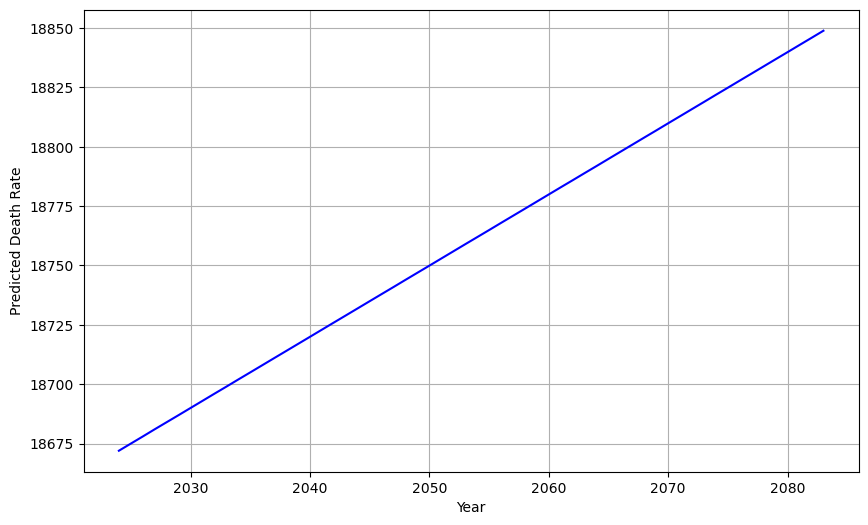

In [32]:
# Here I am applying an offset to stabilize our prediction: in this case it aligns our predictions with the LAST known temperature value
predictions = np.array(predictions) # Convert to array first to apply offset
offset = death_rate_data['Deaths'].iloc[0] - predictions[0]  # Align predictions to the last known temperature
predictions += offset

plt.figure(figsize=(10, 6))
plt.plot(range(2024, 2024 + years), predictions, color='blue')
plt.xlabel('Year')
plt.ylabel('Predicted Death Rate')
plt.grid(True)
plt.show()

### Random Forest Regression

In [36]:
# Load the dataset
data = pd.ExcelFile('data/data_partb.xlsx')

# Parse the desired sheet into a DataFrame (replace 'Sheet1' with your actual sheet name)
df = data.parse('ML')

# Now you can access the columns
df.columns

Index(['Year', 'Population', 'Births', 'Deaths',
       'CO2 (million metric tons of carbon dioxide)', 'Average Temp (F)'],
      dtype='object')

In [37]:
# Load the dataset
excel_data = pd.ExcelFile('data/data_partb.xlsx')

# Parse the desired sheet into a DataFrame
data = excel_data.parse('ML')

# Extract relevant columns and handle missing values
data = data[['Year', 'Population', 'CO2 (million metric tons of carbon dioxide)', 'Average Temp (F)', 'Deaths']].dropna()

# Set 'Year' as the index
data.set_index('Year', inplace=True)

# Features and target variable
X = data[['Population', 'CO2 (million metric tons of carbon dioxide)', 'Average Temp (F)']]
y = data['Deaths']  # Replace with 'Birth Rate' if available in your data

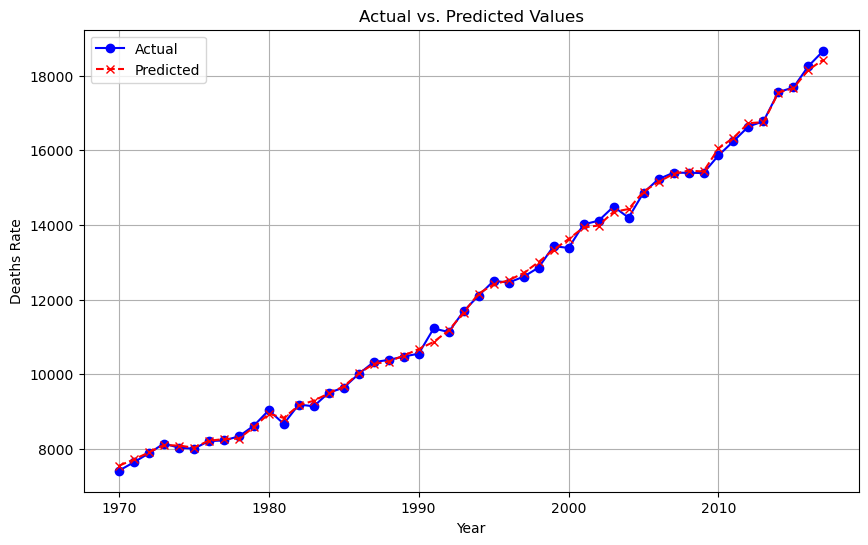

/Users/nicolaaswooters/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


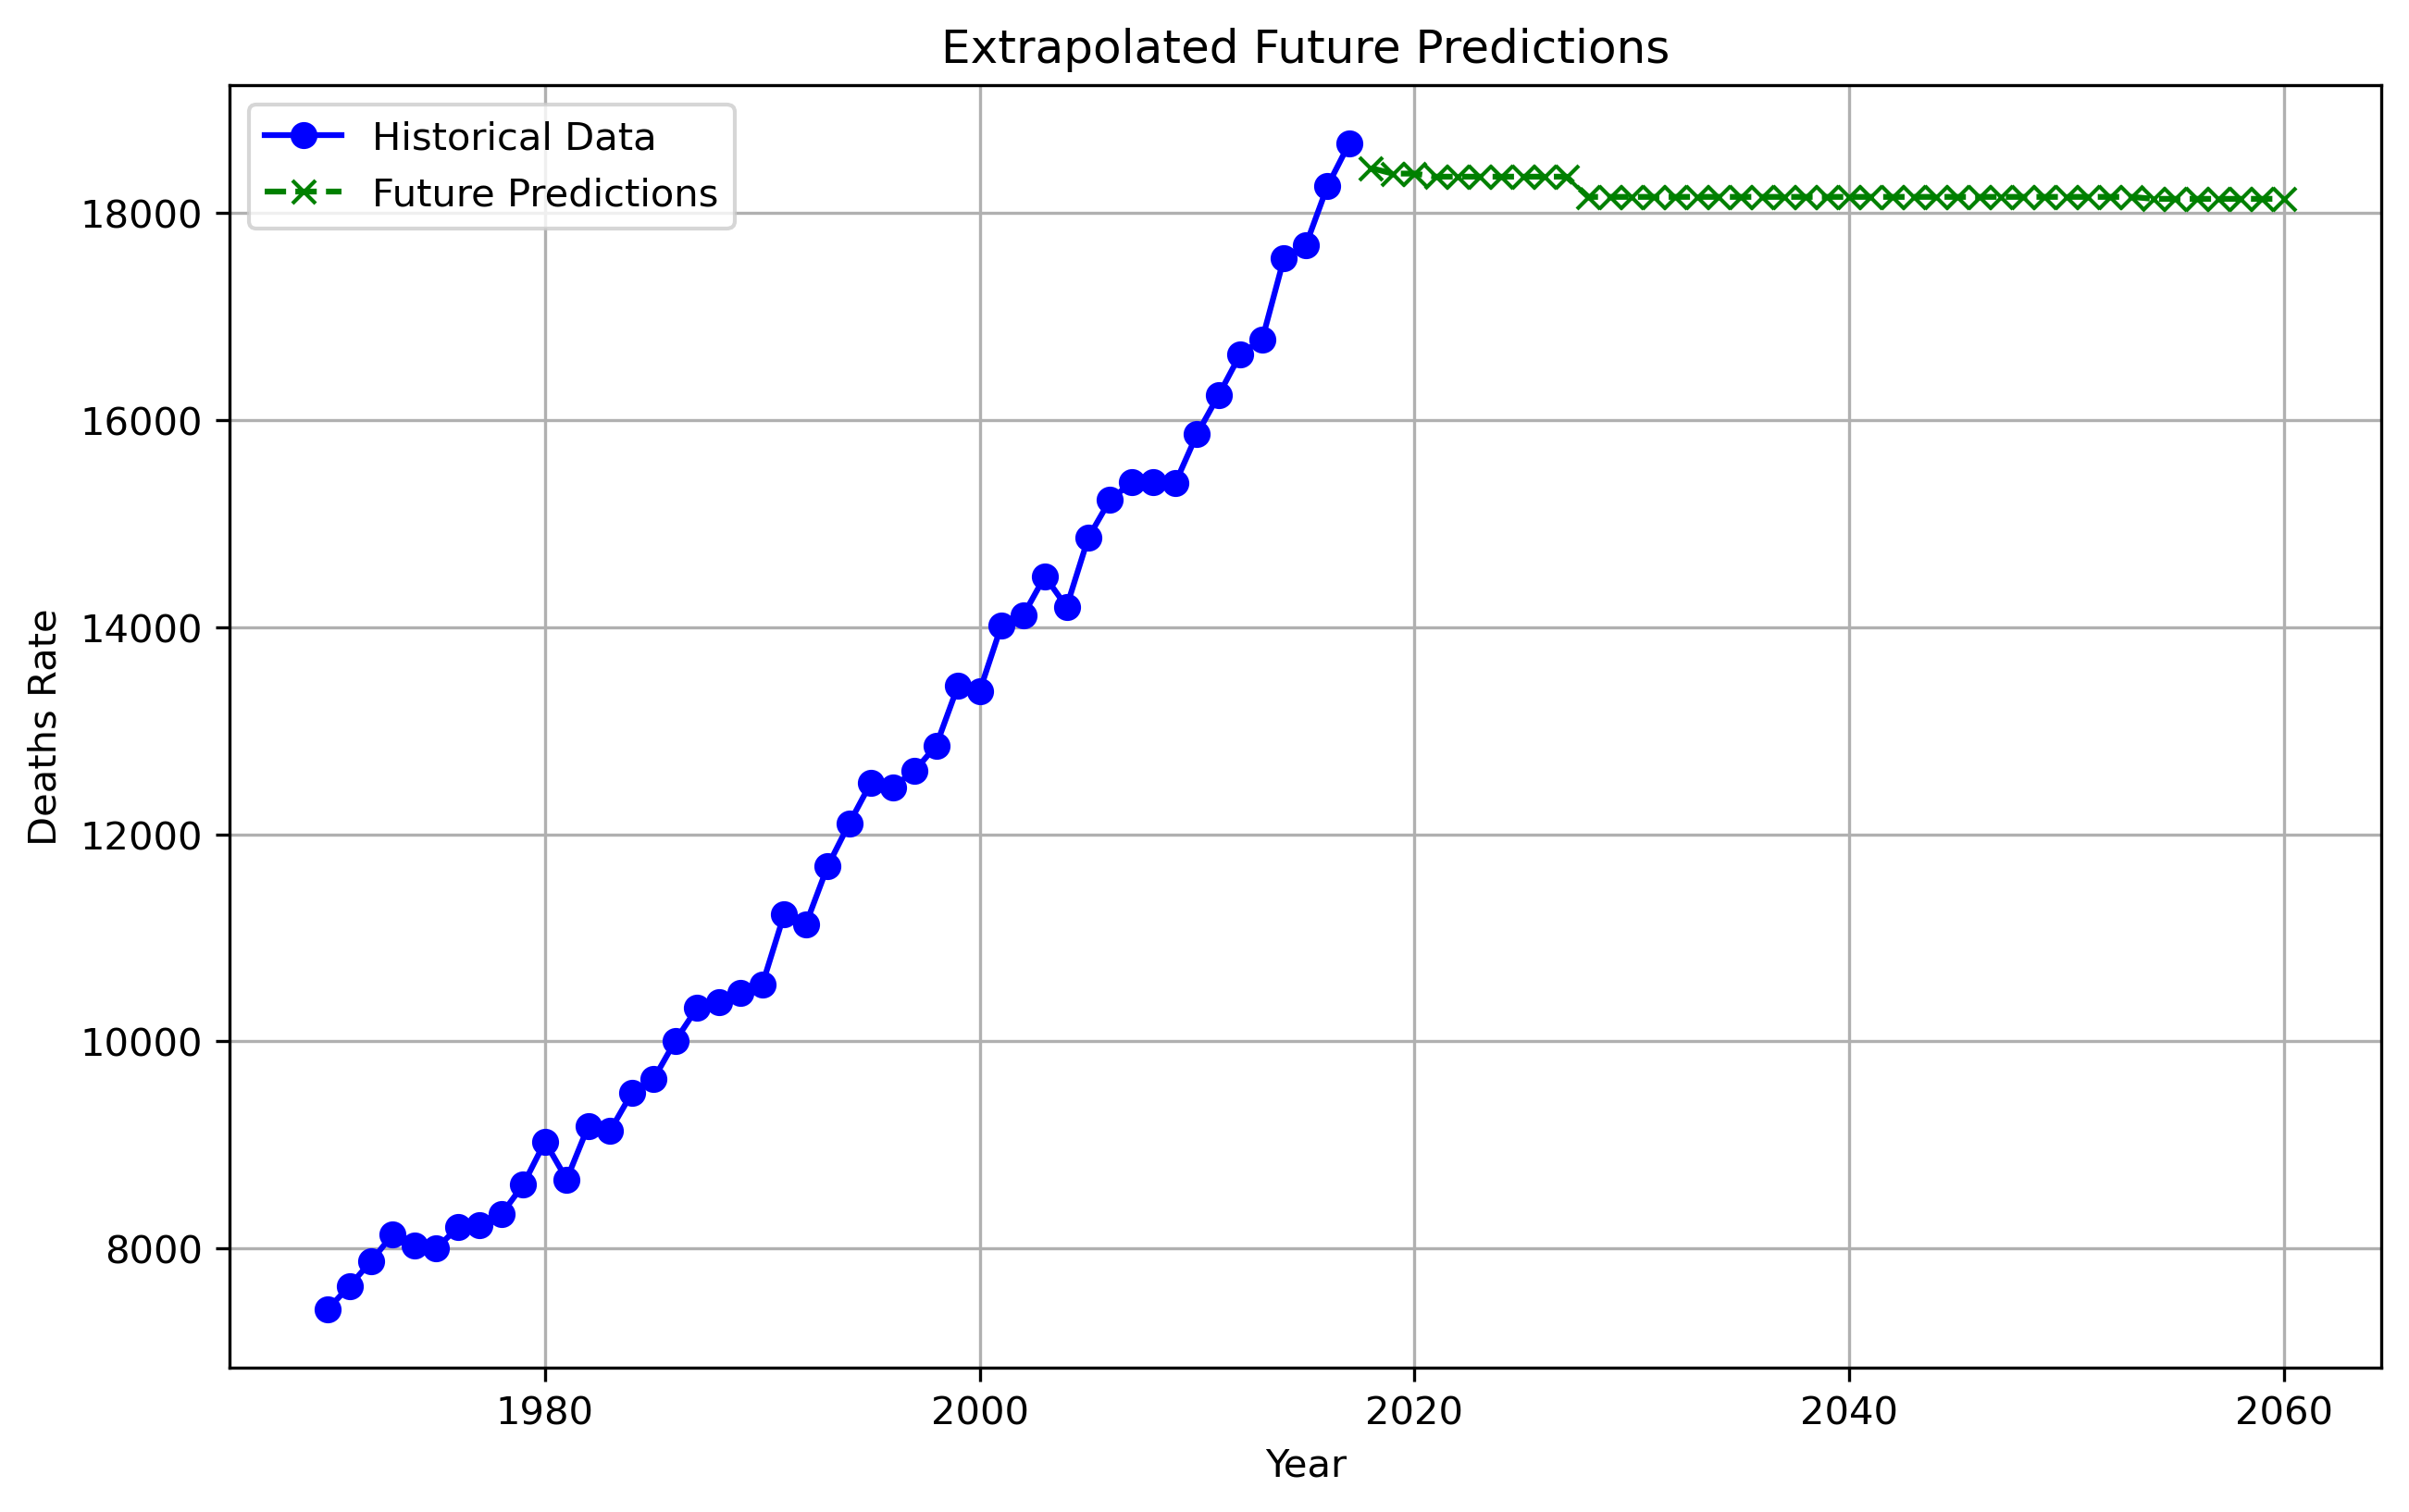

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the model to the entire dataset
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_scaled, y)

# Predictions on the full dataset
y_pred = model.predict(X_scaled)

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(data.index, y, label="Actual", color='blue', marker='o')
plt.plot(data.index, y_pred, label="Predicted", color='red', linestyle='--', marker='x')
plt.title("Actual vs. Predicted Values")
plt.xlabel("Year")
plt.ylabel("Deaths Rate")
plt.legend()
plt.grid()
plt.show()

# Extrapolation: Predict future feature values
future_years = np.arange(2018, 2061)  # Example: Extrapolate for 2018-2061

# Assume linear or polynomial trends for simplicity
future_population = np.linspace(X['Population'].iloc[-1], X['Population'].iloc[-1] * 1.1, len(future_years))
future_CO2 = np.linspace(X['CO2 (million metric tons of carbon dioxide)'].iloc[-1],
                         X['CO2 (million metric tons of carbon dioxide)'].iloc[-1] * 1.05, len(future_years))
future_temp = np.linspace(X['Average Temp (F)'].iloc[-1], X['Average Temp (F)'].iloc[-1] + 2, len(future_years))

# Combine into a future feature matrix
future_data = np.column_stack([future_population, future_CO2, future_temp])

# Scale future data
future_data_scaled = scaler.transform(future_data)

# Predict future target variable
future_predictions = model.predict(future_data_scaled)

# Plot future predictions
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(data.index, y, label="Historical Data", color='blue', marker='o')
plt.plot(future_years, future_predictions, label="Future Predictions", color='green', linestyle='--', marker='x')
plt.title("Extrapolated Future Predictions")
plt.xlabel("Year")
plt.ylabel("Deaths Rate")
plt.legend()
plt.grid()
plt.show()